In [1]:
import numpy as np
import scipy as sp
from importlib import reload
import neuraltda.topology2 as tp2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd
from neuraltda import TPLCP
reload(TPLCP)

/home/brad/.conda/envs/neuraltda-3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<module 'neuraltda.TPLCP' from '/home/brad/code/NeuralTDA/neuraltda/TPLCP.py'>

In [6]:
block_path = '/home/brad/krista/B1075/P01S03/'
block_path = '/home/brad/krista/B1083/P03S03/'
bdf = glob.glob('/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-fulltrial/20170626T223014Z-10.0-5.0.binned')[0]

birds = ['B1083', 'B1075', 'B1235', 'B1056']
#birds = ['B1075']

bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}
B1056_classes = {'A_scaled_burung': 'R', 'B_scaled_burung':'L', 'C_scaled_burung':'R', 'D_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
B1056_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes,
                'B1235': B1235_classes, 'B1056': B1056_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims,
              'B1235': B1235_stims, 'B1056': B1056_stims}

In [7]:
winsize = 10.0
dtovr = winsize*0.5
comment = 'ForLogisticPred'
segment_info = [0,0]

bdfs = []
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good'], dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs.append([bird, bdf])

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T191746Z-10.0-5.0.binned
/home/brad/krista/B1075/P01S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194237Z-10.0-5.0.binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170724T194243Z-10.0-5.0.binned
Data Not already binned
/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForLogisticPred/20170825T212326Z-10.0-5.0.binned


In [10]:
# Behavioral class decoder accuracy vs shuffled. 

reload(tp2)
analysis_id = 'test2'
thresh = 4.0
nperms = 20

ncellsperm = 30
dims = [0,1,2,3,4]
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 60

name = 'ShuffleClassLabels'
acframe_behavioralclass = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    stimc = stim_classes[bird]
    stims = bird_stims[bird]
    (bcAll, t, t_ms) =tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    

    accuracies = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_behavioralclass = acframe_behavioralclass.append(acframeapp)
    acframe_behavioralclass = acframe_behavioralclass.append(acframeapps)

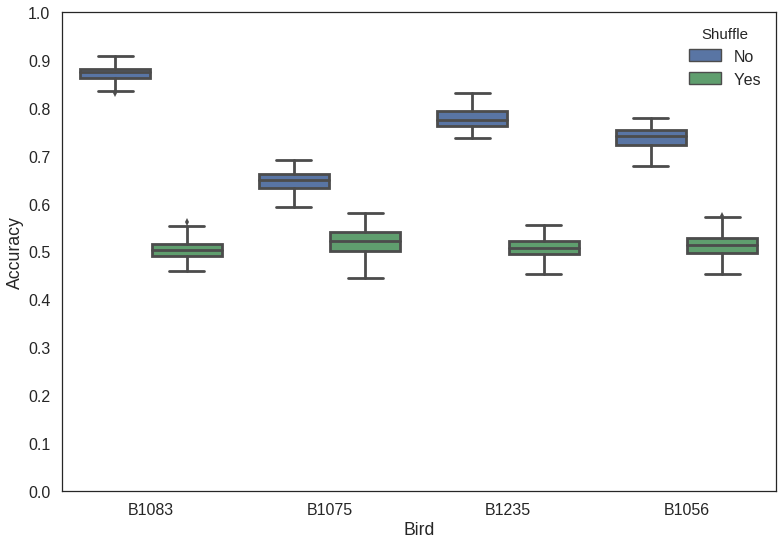

In [11]:
sns.set_context('poster')
sns.set_style('white')
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_behavioralclass)
plt.plot()
plt.ylim([0, 1])
plt.yticks([x/10 for x in range(11)])
plt.savefig('/home/brad/DailyLog/20170825/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

In [ ]:
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1083_unfclasses = {'I_40k': 'L', 'J_40k': 'R', 'K_40k': 'L', 'L_40k':'R'}

B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
unfstims = ['I_40k', 'J_40k', 'K_40k', 'L_40k']

accuracies = TPLCP.predict_stimuli_classes([bc1, bc2, bc0], Ntimes, stims, B1083_classes, p_test, N_tests)
print(np.mean(accuracies))

unfacc = TPLCP.predict_stimuli_classes([bc1, bc2, bc0], Ntimes, unfstims, B1083_unfclasses, p_test, N_tests)
print(np.mean(unfacc))

In [12]:
# Decode stimulus name

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes, 'B1235': B1235_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims, 'B1235': B1235_stims}



# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}
B1056_classes = {'A_scaled_burung': 'R', 'B_scaled_burung':'L', 'C_scaled_burung':'R', 'D_scaled_burung':'L'}

stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1083_stims = ['M_40k', 'N_40k', 'O_40k', 'P_40k']
B1075_stims = ['E_40k', 'F_40k', 'G_40k', 'H_40k']
B1235_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung']
B1056_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung']

stim_classes = {'B1083': B1083_classes, 'B1075': B1075_classes,
                'B1235': B1235_classes, 'B1056': B1056_classes}
bird_stims = {'B1083': B1083_stims, 'B1075': B1075_stims,
              'B1235': B1235_stims, 'B1056': B1056_stims}
reload(tp2)
analysis_id = 'test'
thresh = 4.0
nperms = 20
ncellsperm = 30

dims = [0,1,2,3, 4]
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 60

name = 'PredictStimulusID'
acframe_stimulusID = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    #stimc = stim_classes[bird]
    #stims = bird_stims[bird]
    (bcAll, t, t_ms) =tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    print('Completed Betti Computation...')

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    
    stims = bcAll.keys()
    stimc = {x: x for x in stims}
    accuracies = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_stimuli_classes(bcAll, Ntimes, stims, stimc, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_stimulusID = acframe_stimulusID.append(acframeapp)
    acframe_stimulusID = acframe_stimulusID.append(acframeapps)

B1083
Completed Betti Computation...
B1075
Completed Betti Computation...
B1235
Completed Betti Computation...
B1056
Completed Betti Computation...


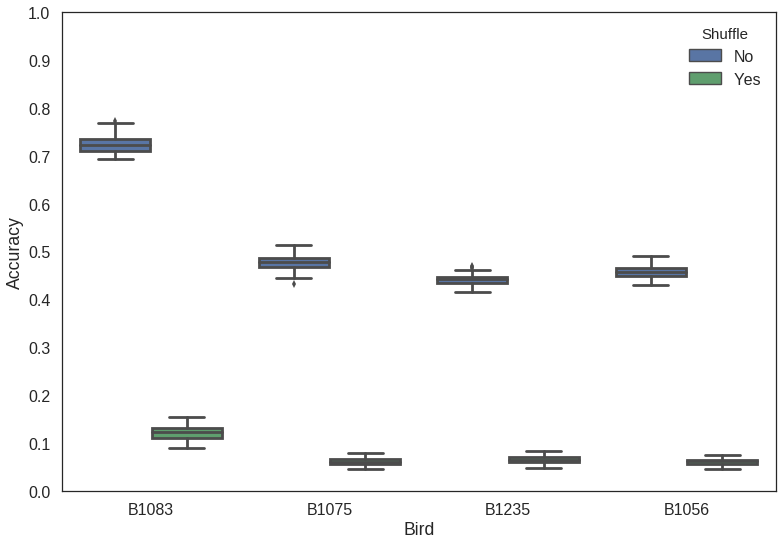

In [13]:
sns.set_context('poster')
sns.set_style('white')
plt.figure()

sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_stimulusID)
plt.ylim([0, 1])
plt.yticks([x/10 for x in range(11)])
plt.savefig('/home/brad/DailyLog/20170825/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

In [14]:
# Decode arbitrary unfamiliar stimuli

# Stim classes
B1083_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1075_classes = {'E_40k': 'R', 'F_40k':'L', 'G_40k':'R', 'H_40k':'L'}
B1087_classes = {'M_40k': 'R', 'N_40k':'L', 'O_40k':'R', 'P_40k':'L'}
B1235_classes = {'E_scaled_burung': 'R', 'F_scaled_burung':'L', 'G_scaled_burung':'R', 'H_scaled_burung':'L'}


B1083_unf_stims = ['I_40k', 'J_40k', 'K_40k', 'L_40k']

B1075_unf_stims = ['A_40k', 'B_40k', 'C_40k', 'D_40k',
                   'I_40k', 'J_40k', 'K_40k', 'L_40k',
                   'M_40k', 'N_40k', 'O_40k', 'P_40k']

B1235_unf_stims = ['A_scaled_burung', 'B_scaled_burung', 'C_scaled_burung', 'D_scaled_burung',
                   'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',
                   'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung',]

B1056_unf_stims = ['E_scaled_burung', 'F_scaled_burung', 'G_scaled_burung', 'H_scaled_burung',
                   'I_scaled_burung', 'J_scaled_burung', 'K_scaled_burung', 'L_scaled_burung',
                   'M_scaled_burung', 'N_scaled_burung', 'O_scaled_burung', 'P_scaled_burung',]

stimclab = ['R', 'L']
bird_unf_stims = {'B1083': B1083_unf_stims, 'B1075': B1075_unf_stims,
                  'B1235': B1235_unf_stims, 'B1056': B1056_unf_stims}

reload(tp2)
analysis_id = 'test2'
thresh = 4.0
nperms = 20
ncellsperm = 30
dims = [0,1,2,3, 4]
Ntimes = 10
twin = np.linspace(0, 6000, Ntimes)
p_test = 0.2
N_tests = 60

name = 'PredictArbitraryUnfamiliar'
acframe_arbunf = pd.DataFrame(columns=['Bird', 'Accuracy', 'Shuffle'])
for b in bdfs:
    bird = b[0]
    bdf = b[1]
    print(bird)
    #stimc = stim_classes[bird]
    stims = bird_unf_stims[bird]
    (bcAll, t, t_ms) =tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, dims, twin, winsize, dtovr)
    print('Completed Betti Computation...')

    #bc2s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 2, twin, winsize, dtovr, shuffle=True)
    #bc1s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 1, twin, winsize, dtovr, shuffle=True)
    #bc0s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 0, twin, winsize, dtovr, shuffle=True)
    #bc3s, ts, ts_ms) = tp2.compute_betti_curves(analysis_id, block_path, bdf, thresh, nperms, ncellsperm, 3, twin, winsize, dtovr, shuffle=True)
    
    
    stims = bcAll.keys()
    
    accuracies = TPLCP.predict_arbitrary_classes(bcAll, stims, stimclab, p_test, N_tests)
    accuracies_shuff = TPLCP.predict_arbitrary_classes(bcAll, stims, stimclab, p_test, N_tests, shuff_Y=True)
    acframeapp = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies, 'Shuffle': N_tests*['No'] })
    acframeapps = pd.DataFrame({'Bird': N_tests*[bird], 'Accuracy': accuracies_shuff, 'Shuffle': N_tests*['Yes'] })
    acframe_arbunf = acframe_arbunf.append(acframeapp)
    acframe_arbunf = acframe_arbunf.append(acframeapps)

B1083
Completed Betti Computation...
B1075
Completed Betti Computation...
B1235
Completed Betti Computation...
B1056
Completed Betti Computation...


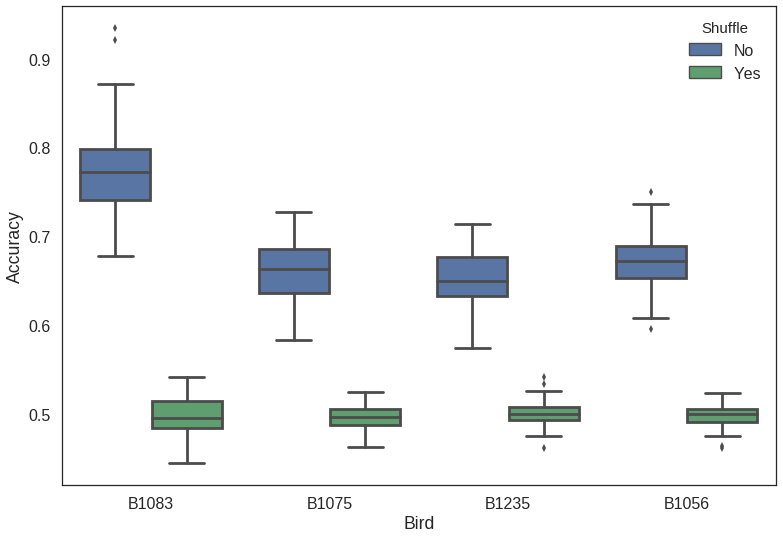

In [15]:
 
plt.figure()
sns.boxplot(x='Bird', y='Accuracy', hue='Shuffle', data=acframe_arbunf)
plt.savefig('/home/brad/DailyLog/20170825/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))

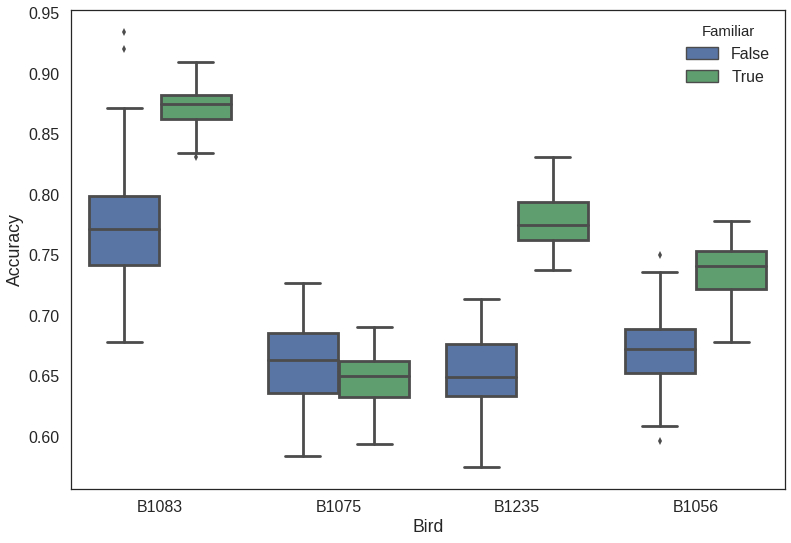

In [16]:
# plot familiar vs. unfamiliar
acframe_arbunf['Familiar'] = len(acframe_arbunf)*[False]
acframe_behavioralclass['Familiar'] = len(acframe_behavioralclass)*[True]

acframe_fam_unf = acframe_arbunf.append(acframe_behavioralclass)

name = 'FamilarvsUnfamiliar'
sns.boxplot(x='Bird', y='Accuracy', hue='Familiar', data=acframe_fam_unf[acframe_fam_unf['Shuffle']=='No'])
plt.savefig('/home/brad/DailyLog/20170825/{}-{}-{}-{}-{}-{}-{}-{}-{}.eps'.format(winsize, dtovr, thresh, nperms, ncellsperm, Ntimes, p_test, N_tests, name))